# Part 2 - Exploratory Data Analysis (EDA)

In this notebook we perform an Exploratory Data Analysis (EDA) of our San Francisco housing prices dataset.  
It is always best to start with an EDA *before* training your machine learning algorithm.  
EDA uses statistical and visualization techniques to give us more insight about our dataset.  
  
**Note:** Most of these EDA techniques were adopted from various [Kaggle] kernels. I'd like to thank those authors for their generous contributions to the Data Science and Machine Learning community  

### Upon completing this notebook, we will have:  
* Familiarity with [Pandas] and [NumPy] for data management and analysis
* Familiarity with [Matplotlib] and [seaborn] for visualization
* A better understanding of the characteristics of our dataset
[Pandas]: https://pandas.pydata.org/
[NumPy]: http://www.numpy.org/
[Matplotlib]: https://matplotlib.org/
[seaborn]: https://seaborn.pydata.org/
[Kaggle]: https://www.kaggle.com/

In [1]:
# some python libs are missing if using Colab
!pip install geopy geojson folium branca

tb-nightly 1.8.0a20180424 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
bleach 2.1.3 has requirement html5lib!=1.0b1,!=1.0b2,!=1.0b3,!=1.0b4,!=1.0b5,!=1.0b6,!=1.0b7,!=1.0b8,>=0.99999999pre, but you'll have html5lib 0.9999999 which is incompatible.


In [4]:
import os
import re
import time
import random
import glob
import zipfile
import urllib.request
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from geopy import Nominatim
import geojson
import folium
from branca.colormap import LinearColormap, StepColormap
from IPython.display import clear_output

%matplotlib inline

Load the data from previous notebook

If running on colab, download the `util.py` script

In [11]:
if not os.path.exists('util.py'):
    data_download_url = 'https://raw.githubusercontent.com/kylehounslow/mlbootcamp/master/notebooks/day1/util.py'
    urllib.request.urlretrieve(data_download_url, 'util.py')
    if os.path.exists('util.py'):
        print("util.py downloaded successfully")
    else:
        print("error downloading util.py. Blame kyle.hounslow@gmail.com")

In [12]:
import util
df = util.load_sf_housing_dataset()
df.head()

downloading data...
extracting data to ./tmp...
Done.
loading data ./tmp/**/*.csv
Found a total of 1262 data points


,title,address,city,state,postal_code,price,facts and features,real estate provider,url,bed,bath,sqft,property_type
0,New Construction,288 Pacific Ave # 67UQRR,San Francisco,CA,94111,NaN,"-- bds , -- ba , -- sqft",NaN,https://www.zillow.com/community/288-pacific/2...,NaN,NaN,NaN,new
1,Condo For Sale,733 Front St UNIT 606,SAN FRANCISCO,CA,94111,1195000.0,"1 bd , 1 ba , 920 sqft",Climb Real Estate,https://www.zillow.com/homedetails/733-Front-S...,1.0,1.0,920.0,condo
2,Condo For Sale,101 Lombard St APT 401W,SAN FRANCISCO,CA,94111,1425000.0,"2 bds , 2 ba , 1,238 sqft",Paragon Real Estate Group,https://www.zillow.com/homedetails/101-Lombard...,2.0,2.0,1238.0,condo
3,Condo For Sale,111 Chestnut St UNIT 109,SAN FRANCISCO,CA,94111,1600000.0,"2 bds , 2 ba , 1,925 sqft",CENTURY 21 Real Estate Alliance,https://www.zillow.com/homedetails/111-Chestnu...,2.0,2.0,1925.0,condo
4,Lot/Land For Sale,1235 Sansome St,San Francisco,CA,94111,998000.0,"6,882 sqft lot",NaN,https://www.zillow.com/homedetails/1235-Sansom...,NaN,NaN,6882.0,lot


We will use `Seaborn` to visualize the data.

### Plot histogram of prices

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


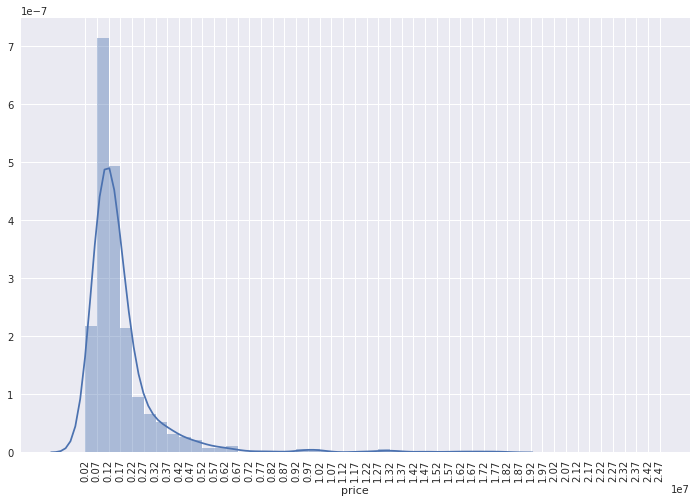

In [13]:
# globally set our seaborn plot size to 12 by 8 inches:
sns.set(rc={'figure.figsize':(12, 8)})

def plot_prices(df: pd.DataFrame, bins: list):
    fig, ax = plt.subplots()
    ax.set_xticks(bins)
    plt.xticks(rotation='vertical')
    return sns.distplot(df.price, bins=bins)

bins = range(int(df.price.min()), int(df.price.max()), 500000)
plot_prices(df.dropna(), bins)

### Definitely a skewed distribution, looks as if we have a few outliers at the higher range of the prices.  
### We can quantify how "non-normal" our distribution is by calculating:  
* `Skewness` - A measure of the symmetry (or lack thereof) of a distribution
* `Kurtosis` - Whether distrubition is "heavy-tailed" or "light-tailed" or in other words: how "sharp" the peak is.

In [128]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

Skewness: 4.360084
Kurtosis: 26.174060


## Plot with outliers removed

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness (outliers removed): 1.927261
Kurtosis (outliers removed): 3.995836


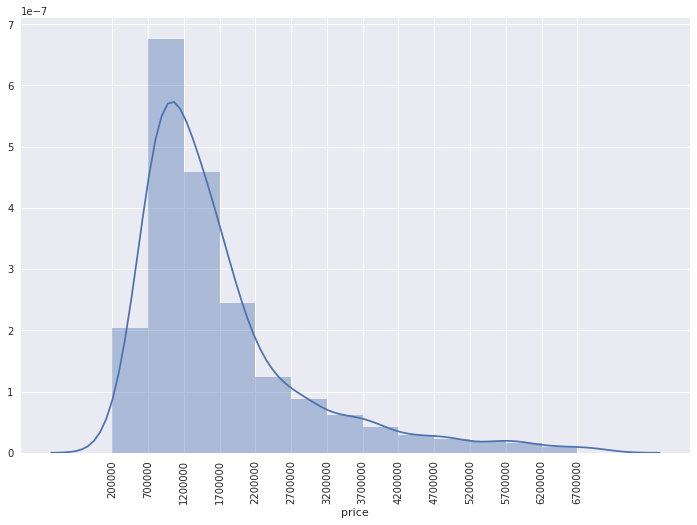

In [129]:
df_no_outliers = df[df.price < 7e6]
bins = range(int(df_no_outliers.price.min()),int(df_no_outliers.price.max()),500000)
plot_prices(df_no_outliers, bins)
print("Skewness (outliers removed): %f" % df_no_outliers['price'].skew())
print("Kurtosis (outliers removed): %f" % df_no_outliers['price'].kurt())

### Removing the outliers improved our skewness and kurtosis values.
We will remember this when cleaning the data for our model. Machine learning models work best with normally distributed data. Outliers may affect model performance.

## Plot missing values.
Recall that there were some columns which are incomplete. Plot a bar graph describing this:

In [ ]:
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

Variables that are missing values can either be removed from the dataset or have their missing values replaced (perhaps with 0 or the mean of the column). This is called **Imputing**. We will learn about imputing data in a later notebook

## Visualize the house prices w.r.t. location with a slippy map  
We have some location information in the `address` column. We can use geocoding to convert the string address to Lat Long.  

Define our geocoding function:

In [ ]:
NUM_RETRIES = 3 # number of retries for request
def address_to_latlng(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    Fetch LatLng coords using Nominatim
    
    Args:
        dataframe: pd.DataFrame containing `address` and `city` columns
    Returns:
        pd.DataFrame: dataframe with `latlng` column added
        
    """
    dataframe = dataframe.copy()
    geocoder = Nominatim()
    latlngs = []
    print("fetching LatLng coords...")
    for address, city in zip(dataframe.address, dataframe.city):
        time.sleep(int(random.randint(0,6)/3)) # try not to get your ip blacklisted by Nominatim
        clear_output(wait=True)
        location = None
        for i in range(NUM_RETRIES):
            try:
                location = geocoder.geocode(f'{address} {city}')
                break
            except Exception as e:
                print(f"Error: {e}")
        if location:
            latlngs.append((location.latitude, location.longitude))
        else:
            latlngs.append(None)
        print(f'{len(latlngs)+1}/{len(dataframe)} complete...')
    dataframe['latlng'] = latlngs
    return dataframe

The above function `generate_latlng()` takes a while to run since we call a web service `Nominatim` to perform the address --> latlng lookup.  
You can choose to load from a pre-processed csv file `data_w_latlng.csv` which is provided (Recommended)

In [ ]:
# uncomment below to fetch LatLng coords from Nominatim (takes a while ~30mins)
################################################
# df = address_to_latlng(df)
# df.to_csv('data_w_latlng.csv', index=False)
################################################
# load pre-fetched latlng data
df = pd.read_csv(os.path.join(data_dir, 'data_w_latlng.csv'))

The dataframe should now have a new `latlng` column

In [ ]:
df.head(10)

We use [folium](https://github.com/python-visualization/folium) to render the slippy map in the notebook.  
Note that there are hundreds of houses to be displayed and this requires a fair bit of RAM. If your browser crashes you can adjust the amount to be displayed by changing the variable `display_max`.

Define slippy map drawing function:

In [ ]:
def draw_houses_on_map(dataframe: pd.DataFrame):
    dataframe = dataframe.copy()
    # create a folium map object centered in SF
    m = folium.Map(location=(37.7, -122.4))
    # create a colormap of the prices (we limit prices between 5e5 and 10e6)
    colors = ['gray', 'green','blue','red','orange', 'yellow']
    min_price, max_price = 5e5, 6e6
    colormap = StepColormap(colors=colors,vmin=min_price, vmax=max_price, caption='price')
    m.add_child(colormap)
    # amount of points to render on the map. WARNING: significant RAM required to plot all points and may crash your browser 
    display_max = len(dataframe) # plot all
    # display_max = 100 # uncomment and adjust this number if needed
    displayed = 0
    for i, latlng in zip(dataframe.index, dataframe['latlng']):
        price = dataframe.loc[i, 'price']
        if latlng is not None:
            if isinstance(latlng, str):
                lat, lng = latlng.replace('(','').replace(')','').split(',')
                latlng = (float(lat), float(lng))
            if not isinstance(latlng, tuple):
                continue
            style = {'fillColor': colormap(price),
                    'color' : colormap(price)}
            p = geojson.Point(coordinates=(latlng[1], latlng[0]), style=style)
            # build an HTML string to be displayed if we click a marker.
            html_info = '<li>Price: ${}</li><li>Property Type: {}</li>'.format(dataframe.loc[i, 'price'], dataframe.loc[i, 'property_type'])
            m.add_child(folium.Marker(location=latlng, icon=folium.Icon(color='black', icon_color=colormap(price)), popup=folium.Popup(html=html_info)))
            displayed += 1
            if displayed > display_max:
                break
    return m

Draw slippy map:

In [ ]:
draw_houses_on_map(df)

We can observe some patterns w.r.t. location.  
The more expensive homes are Central and North and the "lower" (finger quotes) priced homes are South, West and East.

## Next, let's see how some of the variables interact with the list price.  
Since `price` is the dependent variable which we are trying to predict, it is important to visualize how it relates to the independent variables (`sqft`, `bed`, `bath`, etc.)

### Plot `price` vs. `sqft`

In [ ]:
var = 'sqft'
sns.regplot(df[var], df['price'], fit_reg=False)

The relationship looks linear with some spreading as sqft increases.  
We can also see there are some houses with almost zero square feet! Let's investigate why:  
  
First, a quick note on `pandas.DataFrame` indexing:  
* `df['sqft'] < condition` gives us a "truth array" where True values match the condition and False otherwise. If we index the original DataFrame with this truth array we get a filtered result  
  
See [pandas documentiation on indexing](https://pandas.pydata.org/pandas-docs/stable/indexing.html) for more details

In [ ]:
# filter the DataFrame with nearly zero sqft
df[df['sqft'] < 10].head()

Looks like we have some bad data from the web scraping. We will remember to remove these when we get to our data cleaning notebook

### Plot `price` vs. `bed`  

In [ ]:
var = 'bed'
sns.regplot(df[var], df['price'], fit_reg=False)

We observe a bit of a positive correlation between price and number of bedrooms

### Plot `price` vs. `bath`

In [ ]:
var = 'bath'
sns.regplot(df[var], df['price'], fit_reg=False)

Positive correlation between number of baths and price

## Generate a correlation matrix

A correlation matrix will graphically show us which variables are most correlated to our target variable `price`.  
A positive correlation (w.r.t. price) means as the variable increases, the price increases

In [ ]:
corrmat = df[['price', 'bed', 'bath', 'sqft']].corr()
sns.heatmap(corrmat, vmax=1, square=True);

Observe the `price` across a row or column to get an idea which variables are most likely to correlate to price.

## Categorical Variables.  
So far we have only dealt with numeric variables however there are several non-numerical (**Categorical**) variables to be investigated as well:  
  
Categorical variables are ones which provide information but are not quantified numerically. For instance, the `postal_code` variable gives us information about which neighbourhood the house is located. We found from our map plot that this data may be useful for predicting `price`.  
  
In order to use these categorical variables in our model, we encode them into a numerical representation called a [Dummy Variable]. We cover Dummy Variables in a later notebook.
[Dummy Variable]: https://en.wikipedia.org/wiki/Dummy_variable_(statistics)

In [ ]:
print(df.columns)

Let's choose `property_type`, and `postal_code` to investigate.  
We can use the `unique()` function on the categorical columns to see the different categories.

In [ ]:
print(df['postal_code'].value_counts())
print(df['property_type'].value_counts())

There are some variables with only a single value, let's get rid of that data.

In [ ]:
postal_codes = [
'94530',
'94014',
'94608',
'94607',
'94005',
'94706',
'94501'
]
for postal_code in postal_codes:
    df = df[df.postal_code != int(postal_code)]
property_types = ['townhouse', 'foreclosure']
for property_type in property_types:
    df = df[df.property_type != property_type]
print(df['postal_code'].value_counts())
print(df['property_type'].value_counts())

Visualize these categories as box plots.  
We use the `pandas.melt()` function to flatten our variables into a single column so we can plot.  
The result of using `melt()` is most easily understood by displaying the result.

In [ ]:
vars_to_analyze = ['property_type', 'postal_code']
df_melt = pd.melt(df, id_vars=['price'], value_vars=vars_to_analyze)
for var in vars_to_analyze:
    df_var = df_melt[df_melt['variable'] == var]
    sns.boxplot(x=df_var['value'], y=df_var['price'])
    x=plt.xticks(rotation=45)
    plt.title(var)
    plt.show()

# Save our DataFrame to .csv

In [ ]:
df.to_csv(os.path.join(data_dir,'data.csv'), index=False)

## Hopefully this EDA has improved our intuition about our dataset.  
## In the next notebook, we cover data cleaning!